In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
class BayesianDecisionTheory:
    """
    Bayesian Decision Theory Classifier with configurable cost matrix.
    """
    def __init__(self, cost_matrix=None):
        self.prior_probabilities = {}
        self.class_means = {}
        self.class_covariances = {}
        self.classes = None

    
        self.cost_matrix = cost_matrix if cost_matrix is not None else np.array([[0, 1], [1, 0]])

    def fit(self, X, y):
        """
        Fit the model with training data and calculate priors, means, and covariances.
        X: NumPy array of shape (n_samples, n_features)
        y: NumPy array of shape (n_samples,)
        """
        self.classes = np.unique(y)
        n_samples = len(y)

        for c in self.classes:
            self.prior_probabilities[c] = np.sum(y == c) / n_samples
            class_data = X[y == c]
            self.class_means[c] = np.mean(class_data, axis=0)
            self.class_covariances[c] = np.cov(class_data, rowvar=False)

    def _calculate_likelihood(self, x, class_label):
        """
        Calculate the likelihood of a data point given a class using the multivariate normal distribution.
        """
        mean = self.class_means[class_label]
        covariance = self.class_covariances[class_label]
        n = len(x)
        diff = x - mean

        try:
            inv_cov = np.linalg.inv(covariance)
            det_cov = np.linalg.det(covariance)
            if det_cov == 0:
                return 0

            exponent = -0.5 * diff.dot(inv_cov).dot(diff)
            normalizer = 1 / np.sqrt((2 * np.pi) ** n * det_cov)
            return normalizer * np.exp(exponent)
        except np.linalg.LinAlgError:
            return 0

    def predict_proba(self, X):
        """
        Predict the posterior probabilities for each class.
        X: NumPy array of shape (n_samples, n_features)
        """
        probabilities = []
        for x in X:
            posteriors = {c: self._calculate_likelihood(x, c) * self.prior_probabilities[c] for c in self.classes}
            total_probability = sum(posteriors.values())

            if total_probability > 0:
                for c in posteriors:
                    posteriors[c] /= total_probability

            probabilities.append([posteriors.get(0, 0), posteriors.get(1, 0)])
        return np.array(probabilities)

    def calculate_risk(self, probabilities):
        """
        Calculate the risk for each class based on the cost matrix.
        probabilities: NumPy array of shape (n_samples, n_classes)
        """
        risks = []
        for probs in probabilities:
            risk_0 = probs[0] * self.cost_matrix[0, 0] + probs[1] * self.cost_matrix[0, 1]
            risk_1 = probs[0] * self.cost_matrix[1, 0] + probs[1] * self.cost_matrix[1, 1]
            risks.append([risk_0, risk_1])
        return np.array(risks)

    def predict(self, X):
        """
        Predict class labels by choosing the class with the minimum risk.
        X: NumPy array of shape (n_samples, n_features)
        """
        probabilities = self.predict_proba(X)
        risks = self.calculate_risk(probabilities)
        return np.argmin(risks, axis=1)

    def get_feature_importance(self):
        """
        Calculate feature importance based on covariance matrices.
        """
        importance = np.zeros(len(self.class_means[self.classes[0]]))
        for c in self.classes:
            importance += np.abs(np.diag(self.class_covariances[c]))
        return importance / len(self.classes)


In [9]:
def plot_feature_importance(model, feature_names):
    importance = model.get_feature_importance()
    plt.figure(figsize=(10, 6))
    plt.bar(feature_names, importance, color='skyblue')
    plt.title('Feature Importance in Classification')
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    

def plot_risk_distribution(risks, predictions):
    plt.figure(figsize=(10, 6))
    for i in range(2):
        plt.hist(risks[predictions == i][:, i], bins=20, alpha=0.6, label=f'Class {i} Risk')
    plt.title('Risk Distribution by Predicted Class')
    plt.xlabel('Risk Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    

def plot_confusion_with_risk(y_true, y_pred, risks):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    

In [10]:
def prepare_data(data):

    features = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean']
    X = data[features].values
    y = data['diagnosis'] 

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

In [14]:
data = pd.read_csv('https://github.com/YBIFoundation/Dataset/raw/main/Cancer.csv')
data = data.drop(columns=['id', 'Unnamed: 32'], axis=1)
data = data.assign(diagnosis=(data['diagnosis'] == 'M').astype(int).values)

In [ ]:
data.hist(figsize=(15, 15), bins=30)
plt.show()

Accuracy: 0.94
Average Risk: 17.98


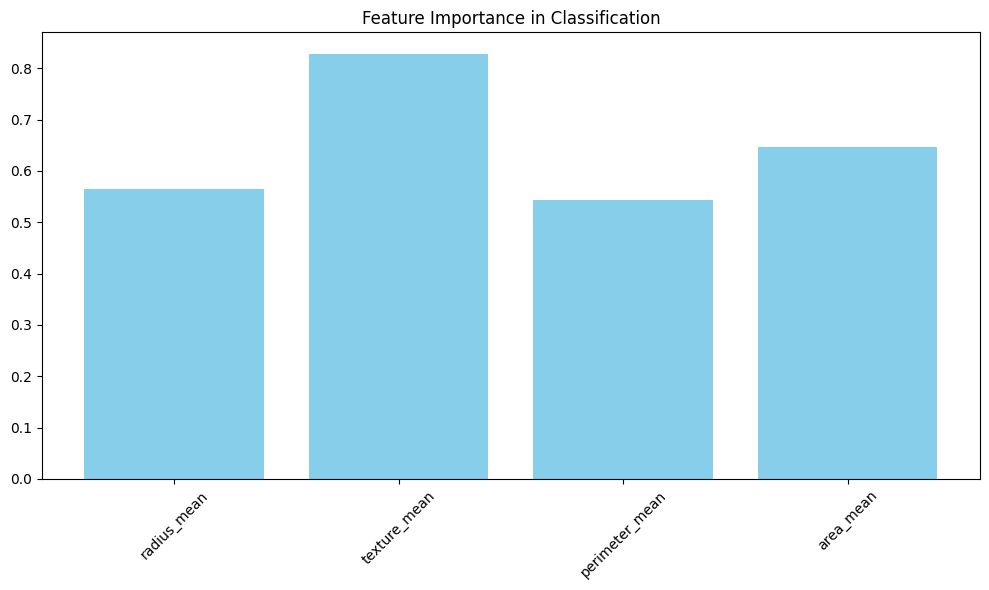

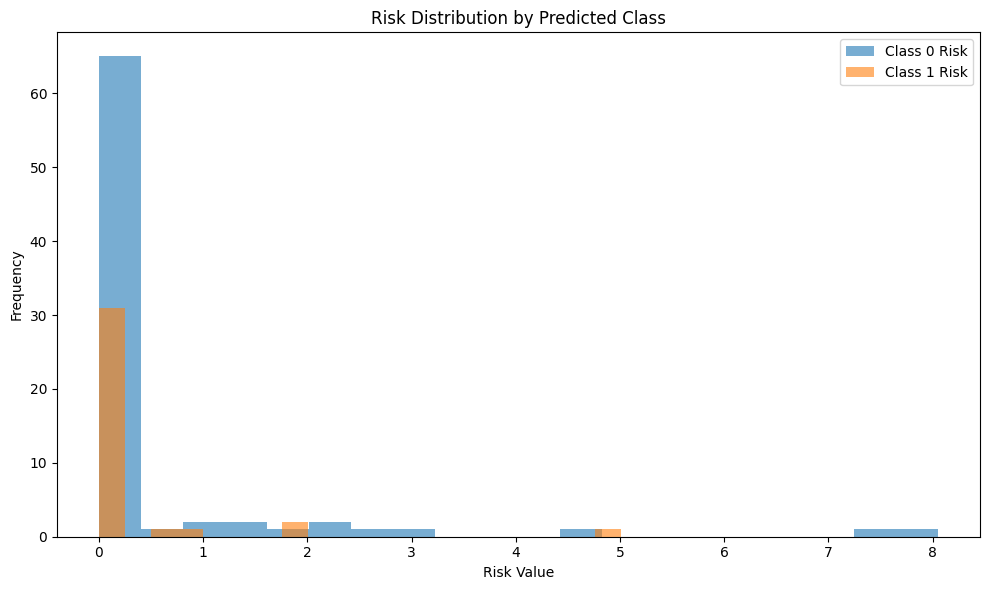

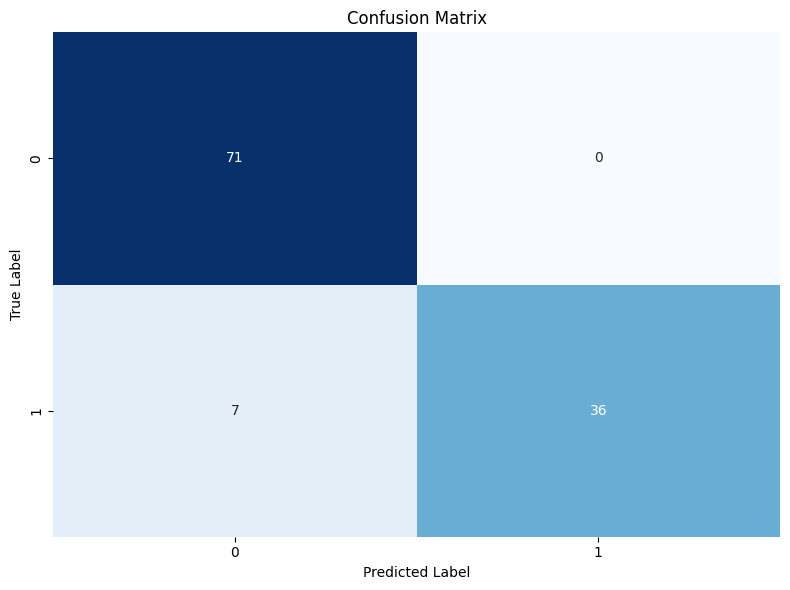

In [ ]:

features = ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean']

X_train, X_test, y_train, y_test = prepare_data(data)

cost_matrix = np.array([[0, 10], [50, 0]])
bdt = BayesianDecisionTheory(cost_matrix=cost_matrix)
bdt.fit(X_train, y_train)

y_pred = bdt.predict(X_test)
probabilities = bdt.predict_proba(X_test)
risks = bdt.calculate_risk(probabilities)
accuracy = np.mean(y_pred == y_test)

print(f"Accuracy: {accuracy:.2f}")
print(f"Average Risk: {np.mean(risks):.2f}")

plot_feature_importance(bdt, features)
plot_risk_distribution(risks, y_pred)
plot_confusion_with_risk(y_test, y_pred, risks)